# 智能计算系统第三次作业
> 朱浩泽 1911530 计算机科学与技术

## 问题一
> 请调研了解常用的图像数据预处理和数据增强方法。实现一个函数，从 ImageN-et2012_val 数据集中选择一张图片文件并读入数据，调整为（256, 256, 3）大小的图片，然后居中裁剪为(224, 224, 3）大小的图片；再实现一个函数，读入数据后居中裁剪为 (0.875 x width, 0.875* height,3）大小的图片，再调整为 (224, 224, 3）大小的图片

### 图像预处理和数据增强方法
- 在图像导入后，为了保证神经网络能够顺利地运行起来，且为了让训练过程变得更加流畅迅速，首先要确保几个问题：
  1. 全部样本的尺寸和通道数是一致的
  2. 图像最终以Tensor形式被输入网络
  3. 图像被恰当地归一化
   
  对于图像来说，所做的预处理主要就是适当的归一化处理和调整尺寸全部相同。
- 对于数据增强，其主要目的是减弱数据量不足所带来的影响，还可以提升模型的鲁棒性、为模型提供各种“不变性”、增加模型抗过拟合的能力,常见的数据增强手段如下：
  1. 添加略微修改的现有数据
  2. 从现有数据中重新合成新数据来增加数据量

### 图像预处理实战
- 首先我们定义一个函数，在数据集中随机选择一张图片

In [ ]:
import tensorflow as tf
import pathlib
import random
import matplotlib.pyplot as plt


def chosen_img(path):
    data_root = pathlib.Path(path)
    img_list = []
    for item in data_root.iterdir():
        img_list.append(str(item))
    chosen = img_list[random.randint(0, len(img_list))]
    return chosen

- 我们将选中的图片以tensor的形式进行保存

In [2]:
def read_img(chosen):
    img_raw = tf.io.read_file(chosen)
    img_tensor = tf.image.decode_image(img_raw)
    return img_tensor

- 定义函数对张量进行处理，调整为（256, 256, 3）大小的图片

In [3]:
def reshape(img_tensor):
    img_reshape = tf.image.resize(img_tensor, [256, 256])
    if img_tensor[0][0][0] > 1:
        img_reshape /= 255
    return img_reshape

- 定义函数将tensor居中裁剪为(224, 224, 3）大小的图片

In [4]:
def cut(img_tensor):
    cut = tf.image.resize_with_crop_or_pad(img_tensor, 224, 224)
    if cut[0][0][0] > 1:
        cut /= 255
    return cut

- 读入数据后进行处理

In [5]:
path = "n04579432"
img_path = chosen_img(path)
img_tensor1 = read_img(img_path)
a = reshape(img_tensor1)
a = cut(a)
img_tensor2 = read_img(img_path)
b = cut(img_tensor2)
b = reshape(b)

2022-03-17 20:24:03.731375: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 20:24:03.732608: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


- 先调整后裁剪的图片如下

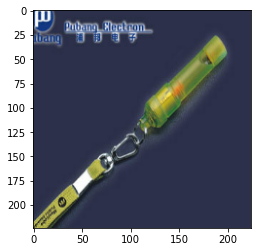

In [6]:
plt.imshow(a)

- 先裁剪后调整的图片如下

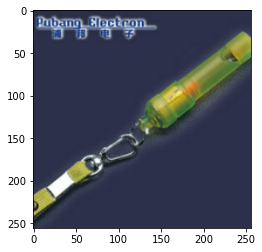

In [7]:
plt.imshow(b)

## 问题二
> 查看 TensorFlow源码，在core/ops中，查找涉及conv算子的代码，请简述算子注册流程。

在Tensorflow的GitHub官方仓库 http://web.stanford.edu/class/cs20si 上寻找有关源代码，找到关于注册的文件tensorflow/tensorflow/core/ops/ragged_conversion_ops.cc和tensorflow/tensorflow/core/ops/conv_ops.cc等

首先要搞清算子的概念，数据流图中的每个节点即代表一个算子(operation)，其接收0个或多个tensor作为输入，产生0个或多个tensor作为输出。整个注册流程大约如下：
1. 用户在前端给出具体的算法以及`Input`(算子输入), `Output`(算子输出), `Attr`(算子属性)
2. 操作被转变为流图
3. 生成 `OpDefBuilderWrapper` 对象
4. 链式调用 `Input`, `Output`, `Attr` 方法并保存到 `OpDefBuilder` 的属性中
5. 对操作进行封装并作为参数传给构造函数


## 问题三
> 查看 TensorFlow 源码，在core/kernel 中，查找涉及conv算子的代码，请简述卷积的具体实现。

在Tensorflow的GitHub官方仓库 https://github.com/tensorflow/tensorflow 上寻找有关源代码，找到关于设计算子的代码tensorflow/tensorflow/core/kernels/conv_2d.h等

首先我们对卷积有一个初步地认识，其主要可类似看作隐藏层中的神经元 具有一个固定大小的感受视野去感受上一层的部分特征，使得在全连接神经网络中，隐藏层中的神经元的感受视野足够大乃至可以看到上一层的所有特征，其实现过成如下：
1. 通过LaunchConvOp实现具体算子的launch
2. 在具体的类中根据卷积核的大小、填充、步长等与原通道分别处理
3. 通过framework进行前置框架的引入和具体矩阵算法的加速

## 问题四
> 现在常见的几种机器学习框架均支持混合精度 (Mixed Precision） 训练方法，该方法采用半精度浮点做正向传播计算，使用单精度浮点做反向传播计算，在训练时需要同时存储半精度和单精度两份数据。调研了解Mixed Precision的具体实现方法，并借鉴此思想，简述如何实现稀疏卷积神经网络模型的训练。注：稀疏卷积神经网络模型一般指卷积层和全连接层的权重中有很多0元素的模型。稀疏模型采用稠密矩阵或者稀疏矩阵方法存储均可。

Mixed Precision:
1. 把weight矩阵转为FP16
2. 利用FP16矩阵（包括激活、W、激活的梯度、W的梯度）进行向前、向后计算
3. 将W的梯度全部从FP16转户为FP32，再更新总的FP32的W（因为总的W也使用FP16，则可能会由于数值指数范围较小或W的梯度的指数小于总的W的指数，在“对齐”过程中梯度很容易对齐到0）
4. 对于某些网络，需要把Loss扩大S倍（目的是把其激活的梯度扩大S倍，从而不至于其一部分数值太小变成0）并在最后W的梯度往总梯度上更新之前，把W的梯度再缩小S倍。

实现稀疏卷积网络的训练:
1. 稀疏动量通过查看最近梯度(动量)的加权平均值来确定在稀疏网络中何处增加新的权值，从而找到一致降低误差的权值和层数
2. 根据平均动量幅值大小确定各层的重要性
3. 对稀疏部分采用 float16 转化，选择性的进行权重备份
4. 对于每一层，去掉50%的最小权值，进行降维处理
5. 根据层的重要性在层之间重新分配权重。在一层中，我们在动量幅值大小较大的地方增加权重


